# 头文件导入

In [1]:
import torch
import torchvision
import torchsummary
import os
import numpy as np
import matplotlib.pyplot as plt

# 常量定义

In [2]:
BATCH_SIZE = 64   
#图像行列像素数量
IMAGE_ROW = 28   
IMAGE_COL = 28
#数据根路径
DATA_SOURCE_DIR = "../datasets/MNIST/raw/"
TRANSFORM = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.,),(1.,))
    ])
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


# 数据集导入

## 官方数据集导入

In [3]:
TRAIN_DATASETS = torchvision.datasets.MNIST(root="../datasets",train=True,download=True,transform=TRANSFORM)
TRAIN_LOADER = torch.utils.data.DataLoader(TRAIN_DATASETS,shuffle=True,batch_size=BATCH_SIZE)
TEST_DATASETS = torchvision.datasets.MNIST(root="../datasets",train=False,download=True,transform=TRANSFORM)
TEST_LOADER = torch.utils.data.DataLoader(TRAIN_DATASETS,shuffle=False,batch_size=BATCH_SIZE)

C:\Users\11426\AppData\Roaming\Python\Python39\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


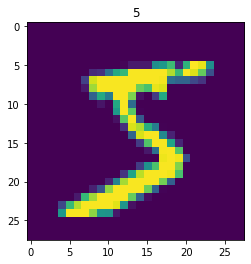

In [4]:
img,label = TRAIN_DATASETS[0]
img = img.numpy()
plt.title(label)
plt.imshow(img[0])

## 自定数据集

In [5]:
import struct
def decode_idx1_ubyte(idx1_ubyte_file):
    with open(idx1_ubyte_file, 'rb') as fp:
        bin_data = fp.read()
        #解析头文件        
        fmt = ">II"
        magic_number,label_number = struct.unpack_from(fmt, bin_data, 0)
        offset = 8 #指针偏移量
        print("magic number:0x{:0>8x}({})\tlabel number:{}".format(magic_number,magic_number,label_number))
        fmt=">B"
        label=[]
        for idx in range(label_number):
            label.append(struct.unpack_from(fmt,bin_data,offset+idx))
    return label
def decode_idx3_ubyte(idx3_ubyte_file):
    with open(idx3_ubyte_file, 'rb') as fp:
        bin_data = fp.read()
        #解析头文件        
        fmt = ">IIII"
        magic_number,image_number,rows,cols = struct.unpack_from(fmt, bin_data,  0)
        offset = 16 #指针偏移量
        print("magic number:0x{:0>8x}({})\t image number:{}".format(magic_number, magic_number, image_number))
        print("rows:{}\t columns:{}".format(rows, cols))
        fmt='>'+str(rows*cols)+'B'
        image=[]
        for idx in range(image_number):
            data = struct.unpack_from(fmt, bin_data, offset+idx*rows*cols)
            data = np.array(data,dtype=np.uint8).reshape((rows, cols))
            image.append(data)
    image = np.array(image)
    return image

In [6]:
class MyMNISTDataSets(torch.utils.data.Dataset):
    def __init__(self,root=DATA_SOURCE_DIR,train=True,transform=None):
        super(MyMNISTDataSets,self).__init__()
        self.root = root
        self.transform = transform
        self.train = train
        if self.train:
            image_path = "train"
            label_path = "train"
        else:
            image_path = "t10k"
            label_path = "t10k"
        image_path = image_path+"-images-idx3-ubyte"
        label_path = label_path+"-labels-idx1-ubyte"
        image_path = os.path.join(self.root,image_path)
        label_path = os.path.join(self.root,label_path)
        self.data, self.targets = decode_idx3_ubyte(image_path),decode_idx1_ubyte(label_path)
        
    def __getitem__(self,idx):
        data,label = self.data[idx], self.targets[idx]
        label = torch.as_tensor(label,dtype=torch.int64)
        if self.transform is not None:
            data = self.transform(data)
        data = data.type(torch.FloatTensor)
        return data,label
    
    def __len__(self):
        return len(self.data)

In [7]:
TRAIN_DATASETS = MyMNISTDataSets(train=True,transform=TRANSFORM)
TRAIN_LOADER = torch.utils.data.DataLoader(TRAIN_DATASETS,shuffle=True,batch_size=BATCH_SIZE)
TEST_DATASETS = MyMNISTDataSets(train=False,transform=TRANSFORM)
TEST_LOADER = torch.utils.data.DataLoader(TRAIN_DATASETS,shuffle=False,batch_size=BATCH_SIZE)

magic number:0x00000803(2051)	 image number:60000
rows:28	 columns:28
magic number:0x00000801(2049)	label number:60000
magic number:0x00000803(2051)	 image number:10000
rows:28	 columns:28
magic number:0x00000801(2049)	label number:10000


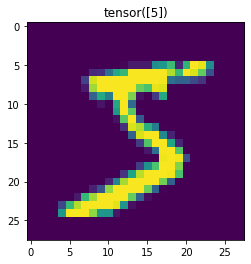

In [8]:
img,label = TRAIN_DATASETS[0]
img = img.numpy()
plt.title(label)
plt.imshow(img[0])

# 网络定义

## 自定义线性网络

In [9]:
class LinearNet(torch.nn.Module):
    def __init__(self):
        super(LinearNet,self).__init__()
        self.l1 = torch.nn.Linear(28*28,512)
        self.l2 = torch.nn.Linear(512,256)
        self.l3 = torch.nn.Linear(256,128)
        self.l4 = torch.nn.Linear(128,64)
        self.l5 = torch.nn.Linear(64,10)
    def forward(self,x):
        x = x.view(-1,IMAGE_ROW*IMAGE_COL)
        x = torch.nn.functional.relu(self.l1(x))
        x = torch.nn.functional.relu(self.l2(x))
        x = torch.nn.functional.relu(self.l3(x))
        x = torch.nn.functional.relu(self.l4(x))
        y = self.l5(x)
        return y
model = LinearNet()
model.to(DEVICE)
torchsummary.summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 128]          32,896
            Linear-4                   [-1, 64]           8,256
            Linear-5                   [-1, 10]             650
Total params: 575,050
Trainable params: 575,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.19
Estimated Total Size (MB): 2.20
----------------------------------------------------------------


## 自定义FCNN

In [10]:
class CNNNet(torch.nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels = 1,out_channels = 10,kernel_size=5)
        self.conv2 = torch.nn.Conv2d(in_channels = 10,out_channels = 20,kernel_size=5)
        self.pooling = torch.nn.MaxPool2d(2)
        self.fc = torch.nn.Linear(in_features = 320,out_features = 10)
        self.relu = torch.nn.ReLU()
    def forward(self,x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.pooling(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.relu(x)
        x = x.view(batch_size,-1)
        x = self.fc(x)
        return x
model = CNNNet()
model.to(DEVICE)
torchsummary.summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
         MaxPool2d-2           [-1, 10, 12, 12]               0
              ReLU-3           [-1, 10, 12, 12]               0
            Conv2d-4             [-1, 20, 8, 8]           5,020
         MaxPool2d-5             [-1, 20, 4, 4]               0
              ReLU-6             [-1, 20, 4, 4]               0
            Linear-7                   [-1, 10]           3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.03
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


C:\Users\11426\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# 模型训练

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

In [19]:
import sys

for epoch in range(2):
    model.train()
    running_loss = 0.0
    for batch_idx,data in enumerate(TRAIN_LOADER):
        inputs,target = data
        inputs,target = inputs.to(DEVICE),target.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        target = target.squeeze()
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if batch_idx % 50 == 49:
            sys.stdout.write("epoch:{:2d}\t {}\t:{:.2%}\t loss:{:.2f}\t\r".format(epoch,"train",(batch_idx+1)/len(TRAIN_LOADER),running_loss/(batch_idx+1)))
            sys.stdout.flush()
    sys.stdout.write('\n')
    sys.stdout.flush()
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx,data in enumerate(TEST_LOADER):
            inputs,target = data
            inputs,target = inputs.to(DEVICE),target.to(DEVICE)
            outputs = model(inputs)
            target = target.squeeze()
            _,predict = torch.max(outputs.data,dim=1)
            total += target.size(0)
            correct += (predict == target).sum().item()
            if batch_idx % 50 == 49:
                sys.stdout.write("epoch:{:2d}\t {}\t:{:.2%}\t accuracy:{:.2%}\t\r".format(epoch,"test",(batch_idx+1)/len(TEST_LOADER),correct/total))
                sys.stdout.flush()
        sys.stdout.write('\n')
        sys.stdout.flush()

epoch: 0	 train	:95.95%	 loss:0.07	
epoch: 0	 test	:95.95%	 accuracy:97.96%	
epoch: 1	 train	:95.95%	 loss:0.06	
epoch: 1	 test	:95.95%	 accuracy:97.95%	


# 结果测试

tensor([[ 14.5856,  -7.1460,   3.1320,  -5.1424, -11.2031,   4.0434,   2.6306,
          -1.8595,  -2.3353,   6.4159]], device='cuda:0')


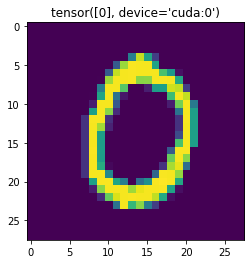

In [20]:
with torch.no_grad():
    choice = np.random.randint(0,len(TEST_DATASETS))
    inputs,target = TEST_DATASETS[choice]
    inputs = torch.as_tensor( inputs.numpy().reshape((1,1,28,28)))
    inputs,target = inputs.to(DEVICE),target.to(DEVICE)
    outputs = model(inputs)
    print(outputs)
    _,predict = torch.max(outputs.data,dim=1)
    plt.title(predict)
    plt.imshow(inputs.to("cpu").numpy()[0,0])